### Sentinel 2 - Timeseries analysis
NDVI, LAI, FAPAR, FCOVER, CAB

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import xarray as xr
from pyproj import Transformer

import distributed
client = distributed.Client()

/home/vhutter/anaconda3/envs/s3_zarr_gdal/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33083 instead
  warnings.warn(


In [2]:
def reproject(spatial_extent_dict: dict = None, x = None, y = None, crs = None):
    if spatial_extent_dict: 
        if not crs:
            crs = spatial_extent_dict["crs"]
        if "4326" in str(crs):
            return spatial_extent_dict
        else:
            transformer = Transformer.from_crs(crs, 4326, always_xy=True)
            west, south = transformer.transform(
                spatial_extent_dict["west"], spatial_extent_dict["south"]
            )
            east, north = transformer.transform(
                spatial_extent_dict["east"], spatial_extent_dict["north"]
            )
            return {
                "west": west,
                "east": east,
                "south": south,
                "north": north,
                "crs": "4326",
            }
    if x and y and crs:
        transformer = Transformer.from_crs(crs, 4326, always_xy=True)
        lon, lat = transformer.transform(
            x, y
        )
        return {"lon": lon, "lat": lat}

In [3]:
def get_file_list(spatial_extent_dict: dict):
    utm_grid = "utm-tiles.geojson"
    utm = gpd.read_file(utm_grid)
    polygon = Polygon(
        [
            [spatial_extent_dict["west"], spatial_extent_dict["south"]],
            [spatial_extent_dict["west"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["north"]],
            [spatial_extent_dict["east"], spatial_extent_dict["south"]],
        ]
    )
    intersection = []
    for i, geom in enumerate(utm.geometry):
        if geom.intersects(polygon):
            intersection.append(utm.Name[i])
    return intersection

# enter the longitude and latitude and use the utm-grid to get the tile
spatial_extent = {"west": 15.649, "east": 15.65, "south": 48.55, "north": 48.551, "crs": 4326}

spatial_extent_4326 = reproject(spatial_extent)

tiles = get_file_list(spatial_extent)

tile = "T" + tiles[0]
print(tile)

transformer = Transformer.from_crs(4326, 32633, always_xy=True)
west, south = transformer.transform(
    spatial_extent["west"], spatial_extent["south"]
)
east, north = transformer.transform(
    spatial_extent["east"], spatial_extent["north"]
)

polygon = Polygon(
    [
        [west, south],
        [west, north],
        [east, north],
        [east, south],
    ]
)

T33UWP


In [4]:
# pick an item from the list provided and get the tile and polygon from there
# fields = gpd.read_file("test_felder.json")
# tile = fields["Name"][2]
# polygon = fields["geometry"][2]
# xp,yp = polygon.exterior.xy
# tile

In [5]:
data = xr.open_zarr(f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-bands-{tile}.zarr", chunks="auto")

data

<xarray.Dataset> Size: 42GB
Dimensions:      (time: 50, y: 10980, x: 10980)
Coordinates:
  * time         (time) <U48 10kB '2024-06-30T09:57:25.299000000' ... '2024-0...
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    blue         (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    green        (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    red          (time, y, x) uint16 12GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    scl          (time, y, x) uint8 6GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    spatial_ref  int32 4B ...

In [6]:
i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))
print(i, j)
a, b = 3000, 3000
if i < 3000 or j < 3000:
    a = np.min([i,j])
if i > np.max(data.x.values) - 3000 or j > np.max(data.y.values) - 3000:
    b = np.min([i, j])


data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

4795 2230
2024-01-10 2024-12-30
CRS:  32633


In [7]:
t0 = 21

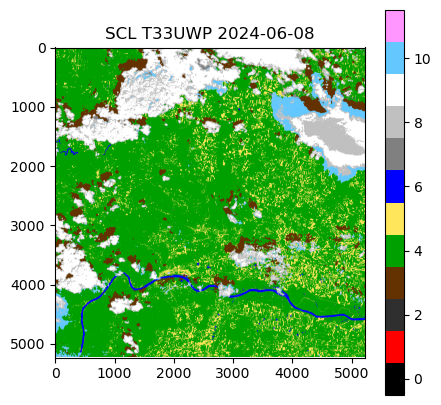

In [8]:
# SCL colormap
from matplotlib import colors

scl_colors = ['#000000', '#FF0000', '#2f2f2f', '#643200', '#00a000', '#ffe65a', '#0000ff', '#808080', '#c0c0c0', '#ffffff', '#64c8ff', '#ff96ff']
scl_cmap = colors.ListedColormap(scl_colors, name="scl")

plt.figure(figsize=(5,5))
plt.title(f'SCL {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.scl[t0, j-a:j+b, i-a:i+b], cmap=scl_cmap, vmin=-0.5, vmax=11.5)
# plt.plot(xp,yp)
plt.colorbar()
plt.show()

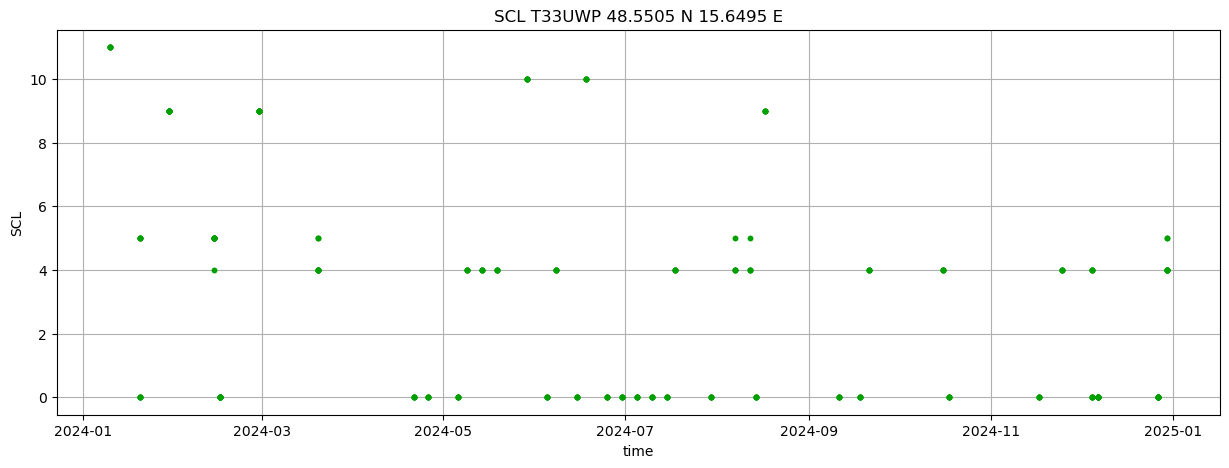

In [9]:
plt.figure(figsize=(15,5))
plt.title(f'SCL {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.scl[:, j-1+yi, i-1+xi], ".", c='#00a000')
plt.xlabel("time")
plt.ylabel("SCL")
plt.grid()
plt.show()

In [10]:
def tone_mapping(data):
    red = data.red[t0, j-a:j+b, i-a:i+b].values
    green = data.green[t0, j-a:j+b, i-a:i+b].values
    blue = data.blue[t0, j-a:j+b, i-a:i+b].values
    red = (red+1)/1733*255
    green = (green+1)/1630*255
    blue = (blue+1)/1347*255
    red = np.clip(red,0,255).astype(np.uint8)
    green = np.clip(green,0,255).astype(np.uint8)
    blue = np.clip(blue,0,255).astype(np.uint8)
    brg = np.zeros((red.shape[0],red.shape[1],3),dtype=np.uint8)
    brg[:,:,0] = red
    brg[:,:,1] = green
    brg[:,:,2] = blue
    return brg

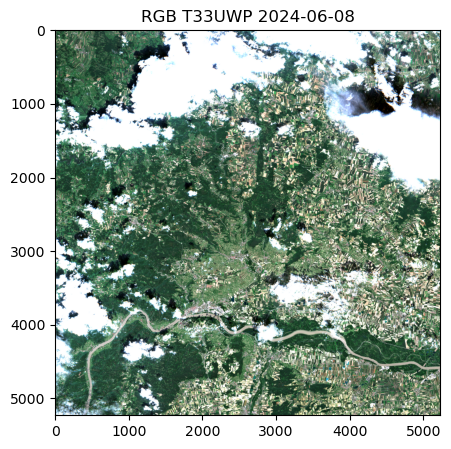

In [11]:
plt.figure(figsize=(15,5))
plt.title(f'RGB {tile} {data["time"].values[t0].astype(str)[:10]}')
plt.imshow(tone_mapping(data), cmap='brg')
plt.show()

2024-01-10 2024-12-30
CRS:  32633


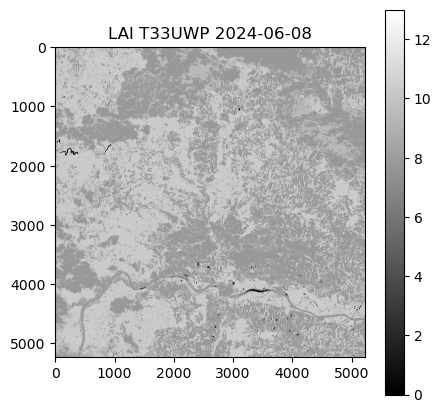

In [12]:
data = xr.open_zarr(f"https://objectstore.eodc.eu:2222/68e13833a1624f43ba2cac01376a18af:indices/s2-indices-{tile}.zarr", chunks="auto")

i = np.argmin(abs(polygon.centroid.x - data.x.values))
j = np.argmin(abs(polygon.centroid.y - data.y.values))

data = data.sortby("time")

t = [(str(time)[:10]) for time in data["time"].values]
t = np.array(t, dtype="datetime64")
print(t[0], t[-1])

crs = int(data["spatial_ref"].values)
print("CRS: ", crs)

x = data["x"][i]
y = data["y"][j]

lon, lat = reproject(x = x, y = y, crs = crs)["lon"], reproject(x = x, y = y, crs = crs)["lat"]

t0 = 15

plt.figure(figsize=(5,5))
plt.title(f'LAI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.lai[t0, j-a:j+b, i-a:i+b], cmap="gray", vmin=0, vmax=13)
plt.colorbar()
plt.show()

In [13]:
data

<xarray.Dataset> Size: 241GB
Dimensions:      (time: 50, y: 10980, x: 10980)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) <U48 10kB '2024-01-10T10:07:17.789000000' ... '2024-1...
  * x            (x) float64 88kB 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 88kB 5.4e+06 5.4e+06 5.4e+06 ... 5.29e+06 5.29e+06
Data variables:
    cab          (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    fapar        (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    fcover       (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    lai          (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    ndvi         (time, y, x) float64 48GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>

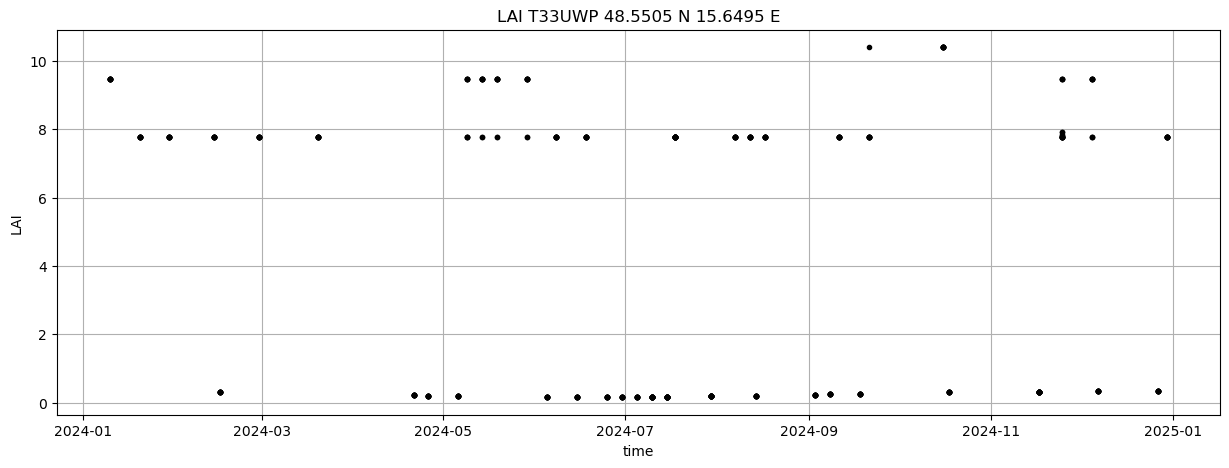

In [14]:
plt.figure(figsize=(15,5))
plt.title(f'LAI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.lai[:, j-1+yi, i-1+xi], ".", c='k')
plt.xlabel("time")
plt.ylabel("LAI")
plt.grid()
plt.show()

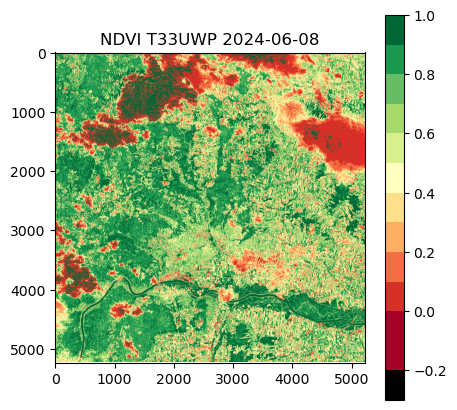

In [15]:
# NDVI colormap
from matplotlib import colors

ndvi_colors = ['#000000', '#a50026', '#a50026', '#d73027', '#f46d43', '#fdae61', '#fee08b', '#ffffbf', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850', '#006837']
ndvi_cmap = colors.ListedColormap(ndvi_colors, name="ndvi")


plt.figure(figsize=(5,5))
plt.title(f'NDVI {tile} {data["time"].values[t0][:10]}')
plt.imshow(data.ndvi[t0, j-a:j+b, i-a:i+b], vmin=-0.3, vmax=1, cmap=ndvi_cmap)
plt.colorbar()
plt.show()

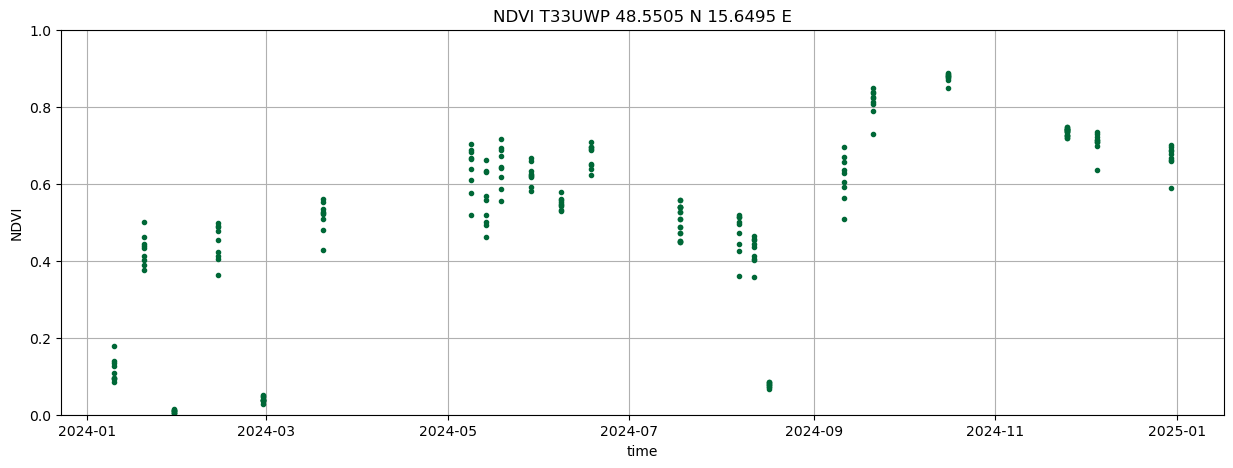

In [16]:
plt.figure(figsize=(15,5))
plt.title(f'NDVI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
for xi in range(3):
    for yi in range(3):
        plt.plot(t, data.ndvi[:, j-1+yi, i-1+xi], ".", c='#006837')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()

In [17]:
NDVI = data.ndvi[:, j, i].values
NDVI

array([0.1265982 , 0.40287185, 0.01369863, 0.42305216,        nan,
       0.0372093 , 0.50768371,        nan,        nan,        nan,
       0.60870594, 0.51922673, 0.61832061, 0.63413029,        nan,
       0.54130975,        nan, 0.64982049,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.48689655, 0.48689655,        nan,        nan, 0.47178955,
       0.41266527,        nan, 0.07692308,        nan,        nan,
       0.60353982,        nan, 0.81282198, 0.87906977,        nan,
              nan,        nan,        nan,        nan, 0.73532864,
       0.73532864, 0.73394495,        nan,        nan, 0.68721109])

In [18]:
t.astype(float)

array([19732., 19742., 19752., 19767., 19769., 19782., 19802., 19834.,
       19839., 19849., 19852., 19857., 19862., 19872., 19879., 19882.,
       19889., 19892., 19899., 19904., 19909., 19914., 19914., 19919.,
       19919., 19922., 19922., 19934., 19934., 19942., 19947., 19949.,
       19952., 19969., 19974., 19977., 19984., 19987., 20012., 20014.,
       20017., 20037., 20044., 20044., 20052., 20052., 20062., 20064.,
       20084., 20087.])

In [19]:
from scipy import optimize

def func(x, *params):
    return params[0] + params[1] * x # + params[2] * x**2

nans = np.isnan(NDVI)

parameters = optimize.curve_fit(func, t.astype(float)[~nans], NDVI[~nans], [0.6, 0])[0]

NDVI_FIT = func(t.astype(float), *parameters)


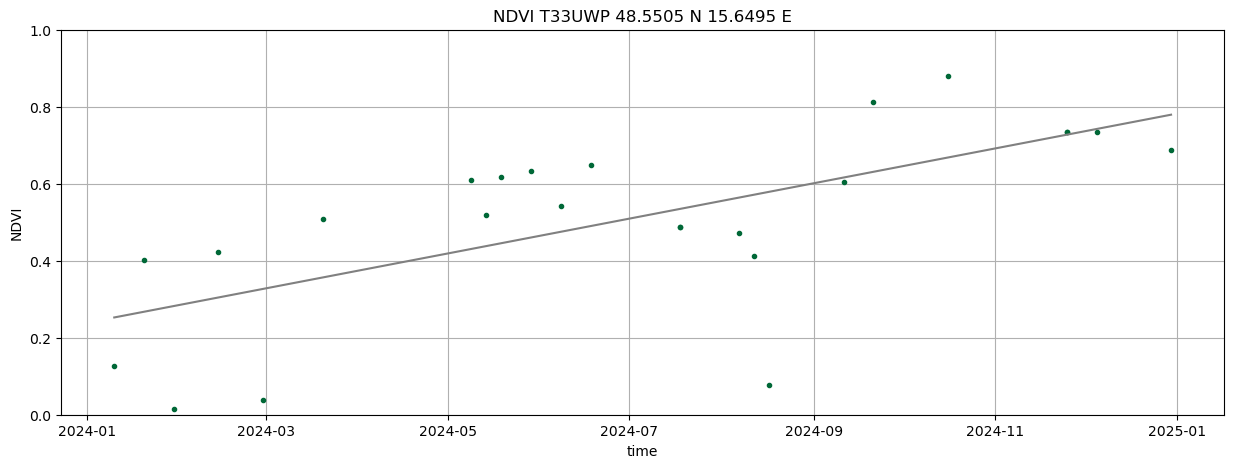

In [20]:
plt.figure(figsize=(15,5))
plt.title(f'NDVI {tile} {np.round(lat, 4)} N {np.round(lon, 4)} E')
plt.plot(t, NDVI, ".", c='#006837')
plt.plot(t, NDVI_FIT, c='grey')
plt.xlabel("time")
plt.ylabel("NDVI")
plt.ylim(0,1)
plt.grid()
plt.show()